In [1]:
from src.seq2seq import *
from src.attention import *
from src.utils import *
from src.layers import MaskedCrossEntropyLoss
import torch 
import torch.optim as optim
import random

# Setup

In [2]:
# OPTIONS: 
# ENGLISH - en, 
# GERMAN - de, 
# FRENCH - fr, 
# CZECH - cs

lang1 = 'en'
lang2 = 'en'

# train_sentences, test_sentences = load_data(lang1, lang2)
# train_sentences = (train_sentences[0][:500], train_sentences[1][:500])
train_sentences = load_summary()

In [3]:
TEST_SIZE=0.2
BATCH_SIZE=64
VALID_BATCH_SIZE=128
MAX_VOCAB=20000

src_vocab, tgt_vocab, train_loader, valid_loader = make_dataset(train_sentences, train_sentences, BATCH_SIZE, VALID_BATCH_SIZE, MAX_VOCAB)

In [4]:
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of validation examples: {len(valid_loader.dataset)}")
print(f"Training Batches {len(train_loader)}\tValidation Batches {len(valid_loader)}")

Number of training examples: 2000
Number of validation examples: 2000
Training Batches 32	Validation Batches 16


In [5]:
print(f"Unique tokens in source ({lang1}) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target ({lang2}) vocabulary: {len(tgt_vocab)}")

Unique tokens in source (en) vocabulary: 6132
Unique tokens in target (en) vocabulary: 3100


# Make the Model

In [6]:
# ENCODER ARGS
ENC_UNITS = 128
ENC_EMBEDDING = 256
SRC_VOCAB_SIZE = len(src_vocab)
ENC_NUM_LAYERS = 1

# ATTENTION DECODER ARGS
DEC_UNITS = ENC_UNITS
DEC_EMBEDDING = ENC_EMBEDDING
TGT_VOCAB_SIZE = len(tgt_vocab)
DEC_NUM_LAYERS = ENC_NUM_LAYERS
'''
Choices = [
    ConcatAttention, GeneralAttention, 
    DotAttention, MeanAttention, LastInSeqAttention
]
'''
ATTN_LAYER = DotAttention
ATTN_HIDDEN_SIZE = 128

# SEQ2SEQ ARGS
TEACHER_FORCING = 0.8
MAX_LENGTH = train_loader.dataset.tensors[1].size(-1) + 1
SOS_TOKEN = tgt_vocab.SOS_token

In [7]:
encoder = Encoder(ENC_UNITS, ENC_EMBEDDING, SRC_VOCAB_SIZE, ENC_NUM_LAYERS)
decoder = AttentionDecoder(DEC_UNITS, DEC_EMBEDDING, TGT_VOCAB_SIZE, DEC_NUM_LAYERS, ATTN_LAYER, ATTN_HIDDEN_SIZE)

seq2seq = Seq2Seq(encoder, decoder, TEACHER_FORCING, MAX_LENGTH, SOS_TOKEN)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters')

The model has 3,108,892 trainable parameters


In [8]:
print(seq2seq)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6132, 256)
    (gru): GRU(256, 128, batch_first=True)
  )
  (decoder): AttentionDecoder(
    (embedding): Embedding(3100, 256)
    (gru): GRU(384, 128, batch_first=True)
    (attention): DotAttention()
    (fc): Linear(in_features=128, out_features=3100, bias=True)
  )
)


In [9]:
criterion = MaskedCrossEntropyLoss(pad_tok=tgt_vocab.PAD_token)
optimizer = optim.Adam(seq2seq.parameters())

# Train

In [10]:
valid_loss = evaluate(seq2seq, valid_loader, criterion)

100%|██████████| 16/16 [00:03<00:00,  5.74it/s]


In [11]:
valid_loss

8.061898708343506

In [12]:
seq2seq.teacher_forcing = 0.

N_EPOCHS = 100
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    
    train_loss = train(seq2seq, train_loader, optimizer, criterion, CLIP, src_vocab.PAD_token)
#     valid_loss = evaluate(seq2seq, valid_loader, criterion)
    valid_loss = evaluate(seq2seq, train_loader, criterion)



    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(seq2seq.state_dict(), 'models/seq2seq_attention.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Epoch: 01
100%|██████████| 32/32 [00:02<00:00, 11.57it/s]
	Train Loss: 7.066 | Train PPL: 1171.069
	 Val. Loss: 6.313 |  Val. PPL: 551.647
Epoch: 02
100%|██████████| 32/32 [00:02<00:00, 10.87it/s]
	Train Loss: 6.281 | Train PPL: 534.211
	 Val. Loss: 6.152 |  Val. PPL: 469.709
Epoch: 03
100%|██████████| 32/32 [00:02<00:00, 11.60it/s]
	Train Loss: 6.155 | Train PPL: 470.984
	 Val. Loss: 6.027 |  Val. PPL: 414.560
Epoch: 04
100%|██████████| 32/32 [00:02<00:00, 11.84it/s]
	Train Loss: 6.038 | Train PPL: 419.181
	 Val. Loss: 5.940 |  Val. PPL: 380.046
Epoch: 05
100%|██████████| 32/32 [00:03<00:00, 10.58it/s]
	Train Loss: 5.956 | Train PPL: 386.038
	 Val. Loss: 5.839 |  Val. PPL: 343.383
Epoch: 06
100%|██████████| 32/32 [00:02<00:00, 10.76it/s]
	Train Loss: 5.851 | Train PPL: 347.505
	 Val. Loss: 5.744 |  Val. PPL: 312.340
Epoch: 07
 34%|███▍      | 11/32 [00:04<00:08,  2.41it/s]


KeyboardInterrupt: 

In [13]:
idx = 666

src_sentence = valid_loader.dataset.tensors[0][idx:idx+1]
tgt_sentence = valid_loader.dataset.tensors[1][idx:idx+1]

print(src_sentence.size(), tgt_sentence.size())

src_sentence = src_vocab.to_string(src_sentence, remove_special=True)[0]
tgt_sentence = tgt_vocab.to_string(tgt_sentence, remove_special=True)[0]

torch.Size([1, 53]) torch.Size([1, 15])


In [14]:
translation, attention = translate(src_sentence, seq2seq, src_vocab, tgt_vocab, src_vocab.PAD_token)

tensor([[   4,  124,  133,   41,  800,  801,  343,   84,   25,   22,   37,  769,
         1734,   78,  326,  286,   44,    2,   59,  312,  191, 1083, 1127,   23,
            2,  121,   76,    3,    5]])
tensor([[1497,    5,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3]])


In [15]:
print(f"> {src_sentence}")
print(f"= {tgt_sentence}")
print(f"< {translation}")

> russian foreign minister sergei lavrov held talks friday with his iranian counterpart amid western concerns over the two countries nuclear cooperation heightened by the georgia crisis .
= russia-iran nuclear talks against backdrop of georgia crisis
< aga in


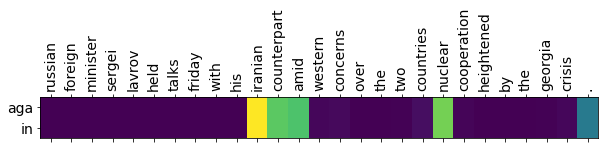

In [16]:
plot_attention(attention, src_sentence, translation)